# Лабораторная №1 - тестируем базовую нейросеть

* Построить различные варианты полносвязных и сверточных нейронных сетей, обучить их на датасете CIFAR-10 (https://www.kaggle.com/competitions/cifar-10/overview) и замерить качество. Провести анализ влияния различных архитектурных и процедурных улучшений на качество модели

* Что обязательно нужно попробовать:
    1. Разбить модель на обучающую и валидационную (тестовую) выборки
    1. Модель только на полносвязных слоях
    (Dense)
    2. Модель со сверточными слоями
    3. Разное количество слоев (и нейронов в слоях)
    4. Дропаут
    5. Batch Normalization
    6. Различные функции активации
    7. Различная инициализация весов
    8. Различные оптимизаторы
    9. Различные расписания обучения (learning rate scheduler)
    10. Разные размеры batch-а и скорости обучения
    11. Подготовить файл с предсказаниями ЛУЧШЕЙ полученной модели и отправить его в ТГ (формат файла есть по ссылке выше, sampleSubmission.csv)

* После каждого эксперимента ожидается вывод с объяснением результатов
* Необязательно делать перебор по сетке, в некоторых экспериментах можно зафиксировать архитектуру и гиперпараметры на основе других экспериментов
* Рекомендуется визуализировать значение метрики и функции ошибок на валидации для каждого эксперимента
* Рекомендруется фиксировать random_state (random_seed) везде, где возможно
* Обратите внимание, что задача - многоклассовая и нужно использовать соответствующие метрики и функцию потерь
* Нормальные значения качества можно посмотреть в соответствующем соревновании (по ссылке), если сильно меньше (0.1-0.2) - возможно что-то пошло не так

# Подготовка данных и модель на полносвязных слоях



In [2]:
import random
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as torch_optim
import torch.nn as nn
import torch.nn.functional as F
from tqdm._tqdm_notebook import tqdm_notebook
from warnings import filterwarnings
from keras.datasets import cifar10

import torchvision.datasets as dsets
import torchvision.transforms as transforms


%matplotlib inline

tqdm_notebook.pandas(desc="Progress:")

<ipython-input-2-2097a4a31236>:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  from tqdm._tqdm_notebook import tqdm_notebook


In [8]:
import torch
import torchvision
import torchvision.transforms as transforms

# Задаем преобразования для нормализации значений пикселей изображений
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Загружаем данные CIFAR-10
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

# Разбиваем данные на обучающую и тестовую выборки
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64,
                                          shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64,
                                         shuffle=False, num_workers=2)


Files already downloaded and verified
Files already downloaded and verified


In [4]:
def show_data(img):
    try:
        plt.imshow(img[0])
    except Exception as e:
        print(e)
    print(img[0].shape, img[0].permute(1,2,0).shape)
    plt.imshow(img[0].permute(1,2,0))
    plt.title('y = '+ str(img[1]))
    plt.show()
    

Invalid shape (3, 32, 32) for image data
torch.Size([3, 32, 32]) torch.Size([32, 32, 3])


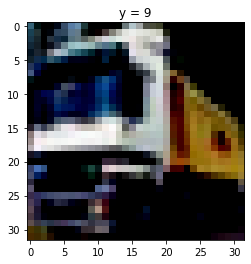

In [24]:
show_data(train_dataset[1])

In [5]:
import torch.nn as nn
import torch.optim as optim

# Создаем модель
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(32*32*3, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 10),
    nn.Softmax(dim=1)
)

Модель на полносвязных слоях


In [6]:
batch_size = 64
learning_rate = 0.001
num_epochs = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# функция потерь и оптимизатор
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Цикл обучения
for epoch in range(num_epochs):
    running_loss = 0.0
    running_corrects = 0
    total = 0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        total += inputs.size(0)

        if (i+1) % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                  .format(epoch+1, num_epochs, i+1, len(train_loader), loss.item()))

    train_loss = running_loss / len(train_dataset)
    train_acc = running_corrects.double() / len(train_dataset)
    running_loss = 0.0
    running_corrects = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            total += inputs.size(0)

    test_loss = running_loss / len(test_dataset)
    test_acc = running_corrects.double() / len(test_dataset)
    print('Epoch [{}/{}], Train Loss: {:.4f}, Train Acc: {:.4f}, Test Loss: {:.4f}, Test Acc: {:.4f}'
          .format(epoch+1, num_epochs, train_loss, train_acc, test_loss, test_acc))


Epoch [1/10], Step [100/782], Loss: 2.1220
Epoch [1/10], Step [200/782], Loss: 2.1146
Epoch [1/10], Step [300/782], Loss: 2.0597
Epoch [1/10], Step [400/782], Loss: 2.1089
Epoch [1/10], Step [500/782], Loss: 2.0965
Epoch [1/10], Step [600/782], Loss: 2.1099
Epoch [1/10], Step [700/782], Loss: 2.0362
Epoch [1/10], Train Loss: 2.0888, Train Acc: 0.3651, Test Loss: 2.0492, Test Acc: 0.4053
Epoch [2/10], Step [100/782], Loss: 2.0067
Epoch [2/10], Step [200/782], Loss: 2.0223
Epoch [2/10], Step [300/782], Loss: 2.0585
Epoch [2/10], Step [400/782], Loss: 1.9549
Epoch [2/10], Step [500/782], Loss: 2.0925
Epoch [2/10], Step [600/782], Loss: 2.0151
Epoch [2/10], Step [700/782], Loss: 1.9513
Epoch [2/10], Train Loss: 2.0324, Train Acc: 0.4236, Test Loss: 2.0207, Test Acc: 0.4340
Epoch [3/10], Step [100/782], Loss: 1.9805
Epoch [3/10], Step [200/782], Loss: 1.9493
Epoch [3/10], Step [300/782], Loss: 2.0525
Epoch [3/10], Step [400/782], Loss: 2.0024
Epoch [3/10], Step [500/782], Loss: 2.0324
Epoch

Кажется, у этой модели получился немаленький Loss 🥲

# NN Model Engineering

In [30]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [31]:
def train_model(model, train_loader, validation_loader, optimizer, n_epochs = 20):
    
    N_test = len(test_dataset)
    accuracy_list = []
    train_loss_list = []
    model = model.to(device)
    train_cost_list = []
    val_cost_list = []
    
    for epoch in range(n_epochs):
        train_COST = 0
        for x,y in train_loader:
            x = x.to(device)
            y = y.to(device)
            model.train()
            optimizer.zero_grad()
            z = model(x)
            loss = criterion(z,y)
            loss.backward()
            optimizer.step()
            train_COST+=loss.item()
            
        train_COST = train_COST/len(train_loader)
        train_cost_list.append(train_COST)
        correct = 0
        
        val_COST = 0
        for x_test, y_test in validation_loader:
            model.eval()
            x_test = x_test.to(device)
            y_test = y_test.to(device)
            z = model(x_test)
            val_loss = criterion(z, y_test)
            _, yhat = torch.max(z.data, 1)
            correct += (yhat==y_test).sum().item()
            val_COST+=val_loss.item()
        
        val_COST = val_COST/ len(validation_loader)
        val_cost_list.append(val_COST)
            
        accuracy = correct / N_test
        accuracy_list.append(accuracy)
        
        print("--> Epoch Number : {}".format(epoch + 1),
              " | Training Loss : {}".format(round(train_COST,4)),
              " | Validation Loss : {}".format(round(val_COST,4)),
              " | Validation Accuracy : {}%".format(round(accuracy * 100, 2)))
        
    return accuracy_list, train_cost_list, val_cost_list

# 2 свертки и 1 соединенный слой


In [12]:
class CNN(nn.Module):

    def __init__(self, out_1 = 32, out_2 = 64, number_of_classes = 10):
        super(CNN, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels = 3, out_channels = out_1, kernel_size = 5, padding = 2)
        self.maxpool1 = nn.MaxPool2d(kernel_size = 2)
        
        
        self.cnn2 = nn.Conv2d(in_channels = out_1, out_channels = out_2, kernel_size = 5, padding = 2)
        self.maxpool2 = nn.MaxPool2d(kernel_size = 2)
        self.fc1 = nn.Linear(out_2 * 8 * 8, number_of_classes)

    def forward(self, x):
        x = self.cnn1(x)
        x = torch.relu(x)
        x = self.maxpool1(x)
        x = self.cnn2(x)
        x = torch.relu(x)
        x = self.maxpool2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return(x)

Точность получилась побольше чем у полносвязной 

In [17]:
model = CNN(out_1=32, out_2=64, number_of_classes = 10)

criterion = nn.CrossEntropyLoss()
learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

validation_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=64)


accuracy_list_normal, train_cost_list, val_cost_list = train_model(model=model,n_epochs=10,train_loader=train_loader,validation_loader=validation_loader,optimizer=optimizer)

--> Epoch Number : 1  | Training Loss : 1.4818  | Validation Loss : 1.3998  | Validation Accuracy : 51.68%
--> Epoch Number : 2  | Training Loss : 1.069  | Validation Loss : 1.0805  | Validation Accuracy : 62.4%
--> Epoch Number : 3  | Training Loss : 0.9011  | Validation Loss : 1.0697  | Validation Accuracy : 63.9%
--> Epoch Number : 4  | Training Loss : 0.791  | Validation Loss : 1.1889  | Validation Accuracy : 60.43%
--> Epoch Number : 5  | Training Loss : 0.7122  | Validation Loss : 0.9814  | Validation Accuracy : 67.35%
--> Epoch Number : 6  | Training Loss : 0.6467  | Validation Loss : 0.9432  | Validation Accuracy : 69.09%
--> Epoch Number : 7  | Training Loss : 0.5912  | Validation Loss : 1.1049  | Validation Accuracy : 66.2%
--> Epoch Number : 8  | Training Loss : 0.5445  | Validation Loss : 1.289  | Validation Accuracy : 63.65%
--> Epoch Number : 9  | Training Loss : 0.5019  | Validation Loss : 1.0295  | Validation Accuracy : 68.6%
--> Epoch Number : 10  | Training Loss : 0.4

# 2 свертки и 2 соединенных слоя, dropout = 0.5

In [18]:
class CNN_V2(nn.Module):    

#    1. 2 convolution
#    2. 2 полностью соединенных слоя
#    3. dropout value = 0.5

    # Constructor
    def __init__(self, out_1 = 32, out_2 = 64, number_of_classes = 10, p = 0):
        super(CNN_V2, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels = 3, out_channels = out_1, kernel_size = 5, padding = 2)
        self.maxpool1 = nn.MaxPool2d(kernel_size = 2)
        
        
        self.cnn2 = nn.Conv2d(in_channels = out_1, out_channels = out_2, kernel_size = 5, padding = 2)
        self.maxpool2 = nn.MaxPool2d(kernel_size = 2)
        self.fc1 = nn.Linear(out_2 * 8 * 8, 1000) # Roughly taken seein the input and the output
        self.drop = nn.Dropout(p=p)
        self.fc2 = nn.Linear(1000, number_of_classes)
        
    # Prediction
    def forward(self, x):
        x = self.cnn1(x)
        x = torch.relu(x)
        x = self.maxpool1(x)
        x = self.cnn2(x)
        x = torch.relu(x)
        x = self.maxpool2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = F.relu(self.drop(x))
        x = self.fc2(x)
        return(x)

In [19]:
model_mmtv2 = CNN_V2(out_1=32, out_2=64, number_of_classes = 10, p=0.5)

criterion = nn.CrossEntropyLoss()
learning_rate = 0.1
optimizer = torch.optim.SGD(model_mmtv2.parameters(), lr = learning_rate, momentum = 0.2)

# Train the model
accuracy_list_normal, train_cost_list, val_cost_list=train_model(model=model_mmtv2,n_epochs=10,train_loader=train_loader,validation_loader=validation_loader,optimizer=optimizer)

--> Epoch Number : 1  | Training Loss : 1.537  | Validation Loss : 1.3794  | Validation Accuracy : 52.87%
--> Epoch Number : 2  | Training Loss : 1.0885  | Validation Loss : 1.0323  | Validation Accuracy : 64.46%
--> Epoch Number : 3  | Training Loss : 0.8789  | Validation Loss : 0.8981  | Validation Accuracy : 68.88%
--> Epoch Number : 4  | Training Loss : 0.7311  | Validation Loss : 0.9533  | Validation Accuracy : 68.2%
--> Epoch Number : 5  | Training Loss : 0.6074  | Validation Loss : 0.7945  | Validation Accuracy : 74.41%
--> Epoch Number : 6  | Training Loss : 0.4969  | Validation Loss : 0.9018  | Validation Accuracy : 70.58%
--> Epoch Number : 7  | Training Loss : 0.3921  | Validation Loss : 0.8456  | Validation Accuracy : 73.26%
--> Epoch Number : 8  | Training Loss : 0.3201  | Validation Loss : 0.8558  | Validation Accuracy : 74.17%
--> Epoch Number : 9  | Training Loss : 0.2627  | Validation Loss : 0.8494  | Validation Accuracy : 76.26%
--> Epoch Number : 10  | Training Loss 

# 2 свертки и 2 соединенных слоя, dropout = 0

In [22]:
class CNN_V2_1(nn.Module):    

    def __init__(self, out_1 = 32, out_2 = 64, number_of_classes = 10, p = 0):
        super(CNN_V2_1, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels = 3, out_channels = out_1, kernel_size = 5, padding = 2)
        self.maxpool1 = nn.MaxPool2d(kernel_size = 2)
        
        
        self.cnn2 = nn.Conv2d(in_channels = out_1, out_channels = out_2, kernel_size = 5, padding = 2)
        self.maxpool2 = nn.MaxPool2d(kernel_size = 2)
        self.fc1 = nn.Linear(out_2 * 8 * 8, 1000) # Roughly taken seein the input and the output
        self.drop = nn.Dropout(p=p)
        self.fc2 = nn.Linear(1000, number_of_classes)
        
    def forward(self, x):
        x = self.cnn1(x)
        x = torch.relu(x)
        x = self.maxpool1(x)
        x = self.cnn2(x)
        x = torch.relu(x)
        x = self.maxpool2(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = F.relu(self.drop(x))
        x = self.fc2(x)
        return(x)

In [23]:
model_mmtv2_1 = CNN_V2_1(out_1=32, out_2=64, number_of_classes = 10, p=0)

criterion = nn.CrossEntropyLoss()
learning_rate = 0.1
optimizer = torch.optim.SGD(model_mmtv2_1.parameters(), lr = learning_rate, momentum = 0.2)

# Train the model
accuracy_list_normal, train_cost_list, val_cost_list=train_model(model=model_mmtv2_1,n_epochs=10,train_loader=train_loader,validation_loader=validation_loader,optimizer=optimizer)

--> Epoch Number : 1  | Training Loss : 1.493  | Validation Loss : 1.6442  | Validation Accuracy : 44.33%
--> Epoch Number : 2  | Training Loss : 1.0225  | Validation Loss : 1.1925  | Validation Accuracy : 58.73%
--> Epoch Number : 3  | Training Loss : 0.7723  | Validation Loss : 0.9059  | Validation Accuracy : 68.17%
--> Epoch Number : 4  | Training Loss : 0.5681  | Validation Loss : 1.4373  | Validation Accuracy : 61.09%
--> Epoch Number : 5  | Training Loss : 0.3762  | Validation Loss : 0.997  | Validation Accuracy : 70.84%
--> Epoch Number : 6  | Training Loss : 0.2185  | Validation Loss : 1.0384  | Validation Accuracy : 71.94%
--> Epoch Number : 7  | Training Loss : 0.1188  | Validation Loss : 1.1429  | Validation Accuracy : 73.05%
--> Epoch Number : 8  | Training Loss : 0.0637  | Validation Loss : 1.3559  | Validation Accuracy : 72.75%
--> Epoch Number : 9  | Training Loss : 0.0492  | Validation Loss : 1.447  | Validation Accuracy : 73.29%
--> Epoch Number : 10  | Training Loss :

# 3 свертки и 3 соединенных слоя, dropout = 0.5 и momentum 0.2

In [25]:
class CNN_V3_V2(nn.Module):
    

    def __init__(self, out_1 = 32, out_2 = 64, out_3 = 128, number_of_classes = 10, p = 0):
        super(CNN_V3_V2, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels = 3, out_channels = out_1, kernel_size = 5, padding = 2)
        self.maxpool1 = nn.MaxPool2d(kernel_size = 2)
        
        self.cnn2 = nn.Conv2d(in_channels = out_1, out_channels = out_2, kernel_size = 5, padding = 2)
        self.maxpool2 = nn.MaxPool2d(kernel_size = 2)
        
        self.cnn3 = nn.Conv2d(in_channels = out_2, out_channels = out_3, kernel_size = 5, padding = 2)
        self.maxpool3 = nn.MaxPool2d(kernel_size = 2)

        self.fc1 = nn.Linear(out_3 * 4 * 4, 1000) 

        self.drop = nn.Dropout(p=p)

        self.fc2 = nn.Linear(1000, 1000)

        self.fc3 = nn.Linear(1000, 10)

    def forward(self, x):
        
        x = self.cnn1(x)
        x = torch.relu(x)
        x = self.maxpool1(x)
        
        x = self.cnn2(x)
        x = torch.relu(x)
        x = self.maxpool2(x)
        
        x = self.cnn3(x)
        x = torch.relu(x)
        x = self.maxpool3(x)
        
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        
        x = F.relu(self.drop(x))
        x = self.fc2(x)
        
        x = F.relu(self.drop(x))
        x = self.fc3(x)
        
        return(x)

In [27]:
model_mmtv4 = CNN_V3_V2(out_1=32, out_2=64, out_3 =128, number_of_classes = 10, p=0.5)

criterion = nn.CrossEntropyLoss()
learning_rate = 0.1
optimizer = torch.optim.SGD(model_mmtv4.parameters(), lr = learning_rate, momentum = 0.2)

accuracy_list_normalv4, loss_list_normalv4=train_model(model=model_mmtv4, n_epochs=10, train_loader=train_loader, validation_loader=validation_loader, optimizer=optimizer)

--> Epoch Number : 1  | Training Loss : 1.7904  | Validation Loss : 2.1726  | Validation Accuracy : 31.37%
--> Epoch Number : 2  | Training Loss : 1.2939  | Validation Loss : 1.3215  | Validation Accuracy : 55.54%
--> Epoch Number : 3  | Training Loss : 1.012  | Validation Loss : 1.2202  | Validation Accuracy : 58.04%
--> Epoch Number : 4  | Training Loss : 0.8282  | Validation Loss : 1.0961  | Validation Accuracy : 63.37%
--> Epoch Number : 5  | Training Loss : 0.6997  | Validation Loss : 0.8486  | Validation Accuracy : 71.54%
--> Epoch Number : 6  | Training Loss : 0.5958  | Validation Loss : 1.2136  | Validation Accuracy : 64.92%
--> Epoch Number : 7  | Training Loss : 0.5115  | Validation Loss : 0.8571  | Validation Accuracy : 73.26%
--> Epoch Number : 8  | Training Loss : 0.4396  | Validation Loss : 0.8775  | Validation Accuracy : 71.71%
--> Epoch Number : 9  | Training Loss : 0.3724  | Validation Loss : 0.8615  | Validation Accuracy : 74.78%
--> Epoch Number : 10  | Training Loss

ValueError: ignored

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(data_train, target, test_size=0.30, random_state=42)

Для удобной работы заведем специальные для загрузчики для выборок:


In [ ]:
# Обратите внимание - размер батча определяется на это этапе
train_dataset = TensorDataset(torch.tensor(X_train_norm_ext.values, dtype=torch.float32), torch.tensor(y_train_ext.values, dtype=torch.float32))
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = TensorDataset(torch.tensor(X_test_norm.values, dtype=torch.float32), torch.tensor(y_test_norm.values, dtype=torch.float32))
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=True)

Базовый вариант архитектуры сети - с возможностью выбирать количество слоев, нейронов в скрытых слоях и промежуточную функцию активации

In [ ]:
# Пример нейронной сети с параметризуемым количеством и размером слоев, 
# а также функцией активации
class NeuralNetwork(nn.Module):
    def __init__(self, 
                 input_size, 
                 num_layers=1, 
                 layer_size=100,
                 activation=F.relu):
        super().__init__()
        
        # Инициализирируем слои
        self.input_layer = nn.Linear(input_size, layer_size)
        self.layers = []
        for _ in range(num_layers - 1):
            self.layers.append(nn.Linear(layer_size, layer_size))
        # ModuleList нужен для того, чтобы to() применялся к модели корректно
        self.layers = nn.ModuleList(self.layers)
        self.output_layer = nn.Linear(layer_size, 1)
        
        # Инициализируем функцию активации
        self.activation = activation

    def forward(self, input):
        output = self.activation(self.input_layer(input))
        for layer in self.layers:
            output = self.activation(layer(output))
        output = self.output_layer(output)
        
        return output

In [ ]:
# Параметризуемая функция - для удобства подбора параметров
def train_model(model, 
                train_dataloader, 
                val_dataloader,
                device, 
                num_epochs = 10,
                lr = 10e-5,
                show=True):
    # Указываем модели, какие параметры сети оптимизировать (обучать)
    # По факту - все, которые имеют градиенты
    parameters = filter(lambda p: p.requires_grad, model.parameters())
    
    # Задаем оптимизатор (можно параметризовать)
    optimizer = torch_optim.Adam(parameters, lr=lr)

    # Задаем функцию потерь (в вашей задаче какую нужно использовать?)
    loss_function = nn.BCEWithLogitsLoss()

    train_losses = []
    train_roc_aucs = []
    val_losses = []
    val_roc_aucs = []

    # Итерируемся по эпохам
    for e in range(num_epochs):
        # Включаем режим обучения - разрешаем менять веса модели
        model.train()

        epoch_train_loss = 0
        epoch_train_roc_auc = 0

        # Проходимся по всему датасету
        for X_batch, y_batch in train_dataloader:
            # Помещаем тензоры на девайс (gpu или cpu в зависимости от инициализации device)
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            # Обнуляем градиенты на каждом шаге обучения
            optimizer.zero_grad()
            
            # Делаем прямое распространение
            y_pred = model(X_batch)
            
            # Считаем значение функции потерь
            loss = loss_function(y_pred, y_batch.unsqueeze(1))

            # Считаем значение метрики (вы можете использовать другую)
            roc_auc = roc_auc_score(y_batch.unsqueeze(1).ravel().cpu(), 
                                    torch.sigmoid(y_pred).ravel().cpu().detach().numpy())
            
            # Делаем обратное распространение ошибки (обновляем веса модели)
            loss.backward()
            # Обновляем состояния оптимизатора
            optimizer.step()
            
            # Накапливаем значение функции потерь и метрики
            epoch_train_loss += loss.item()
            epoch_train_roc_auc += roc_auc.item()

        # Включаем режим оценки - градиенты не накалпиваются при прямом распространении
        model.eval()
            
        epoch_val_loss = 0
        epoch_val_roc_auc = 0

        # Итерируемся по валидационной выборке
        for X_batch, y_batch in val_dataloader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            y_pred = model(X_batch)
            
            loss = loss_function(y_pred, y_batch.unsqueeze(1))
            roc_auc = roc_auc_score(y_batch.unsqueeze(1).ravel().cpu(), 
                                    torch.sigmoid(y_pred).ravel().cpu().detach().numpy())

            epoch_val_loss += loss.item()
            epoch_val_roc_auc += roc_auc.item()
        
        # Считаем средние показатели за эпоху
        train_losses.append(epoch_train_loss / len(train_dataloader))
        train_roc_aucs.append(epoch_train_roc_auc / len(train_dataloader))
        val_losses.append(epoch_val_loss / len(val_dataloader))
        val_roc_aucs.append(epoch_val_roc_auc / len(val_dataloader))

    # Строим график по всем эпохам
    if show:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))
        x = range(len(train_losses))
        ax1.plot(x, train_losses, label='Train')
        ax1.plot(x, val_losses, label='Val')
        ax1.set_title('Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax2.plot(x, train_roc_aucs, label='Train')
        ax2.plot(x, val_roc_aucs, label='Val')
        ax2.set_title('Metric (ROC AUC)')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('ROC AUC')
        ax2.legend()
        plt.show()

    # Возвращаем лучшее значение метрики на валидации
    # Можно возвращать модель или все результаты, или ничего не возвращать
    return np.array(val_roc_aucs).max()

In [ ]:
# Функция для тестирования различных параметров
def test_layer_size(layer_size, num_layers=1, activation=F.relu, num_epochs=10, show=True):
    if show:
        print(f"Нейронов в скрытом слое: {layer_size}, функция активации: {str(activation)}")
    
    model = NeuralNetwork(X_train.shape[1], num_layers=num_layers, layer_size=layer_size, activation=activation)
    # Перемещаем модель в видеопамять, если используется GPU
    model.to(device)
    best_metric = train_model(model, train_dataloader, val_dataloader, device, num_epochs=num_epochs, show=show)
    
    if show:
        print(f"Лучший результат на валидации: {best_metric}")
    
    return best_metric

### Один скрытый слой

Итак, в нейросети только один скрытый слой. Посмотрим на различное количество нейронов и функции активации для нормального количества нейронов

Начнем с количества нейронов в скрытом слое:

Нейронов в скрытом слое: 1, функция активации: <function relu at 0x7f1361c77b90>


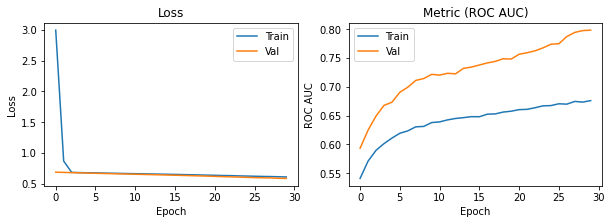

Лучший результат на валидации: 0.7982807058712516


In [ ]:
test_layer_size(1, num_epochs=30);

Нейронов в скрытом слое: 5, функция активации: <function relu at 0x7f1361c77b90>


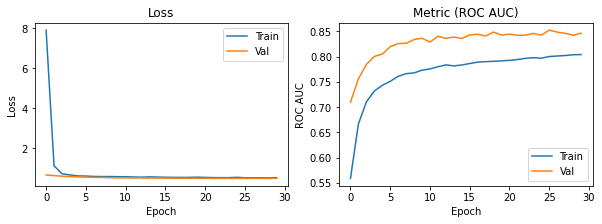

Лучший результат на валидации: 0.8526867357550765


In [ ]:
test_layer_size(5, num_epochs=30);

Нейронов в скрытом слое: 10, функция активации: <function relu at 0x7f7baeda3ef0>


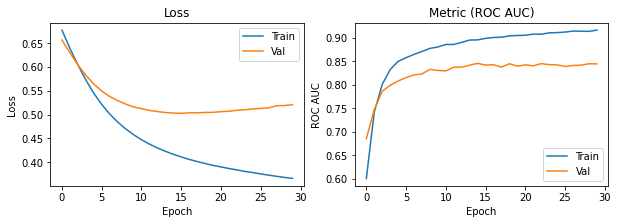

Лучший результат на валидации: 0.845776369442663


In [ ]:
test_layer_size(10, num_epochs=30);

Нейронов в скрытом слое: 25, функция активации: <function relu at 0x7f7baeda3ef0>


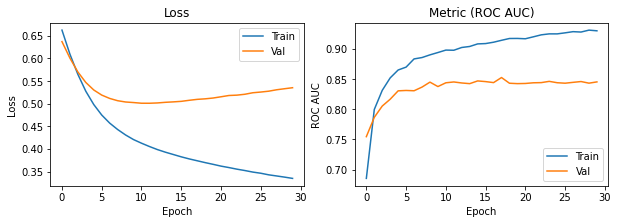

Лучший результат на валидации: 0.8526691906054938


In [ ]:
test_layer_size(25, num_epochs=30);

Нейронов в скрытом слое: 50, функция активации: <function relu at 0x7f7baeda3ef0>


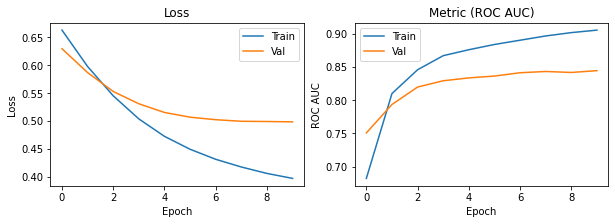

Лучший результат на валидации: 0.8442868333105978


In [ ]:
test_layer_size(50);

Нейронов в скрытом слое: 100, функция активации: <function relu at 0x7f7baeda3ef0>


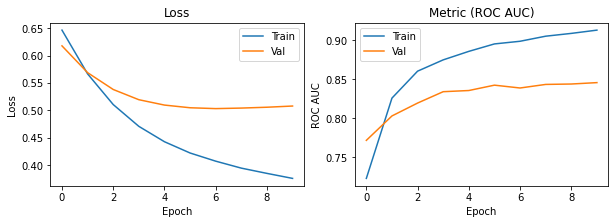

Лучший результат на валидации: 0.8457842137016311


In [ ]:
test_layer_size(100);

Нейронов в скрытом слое: 250, функция активации: <function relu at 0x7f7baeda3ef0>


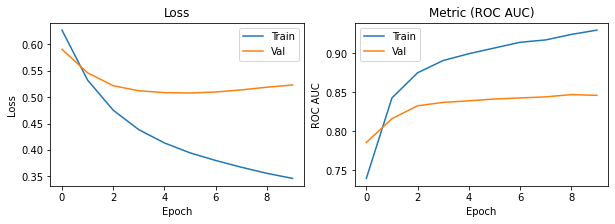

Лучший результат на валидации: 0.8469186587060702


In [ ]:
test_layer_size(250);

Нейронов в скрытом слое: 500, функция активации: <function relu at 0x7f7baeda3ef0>


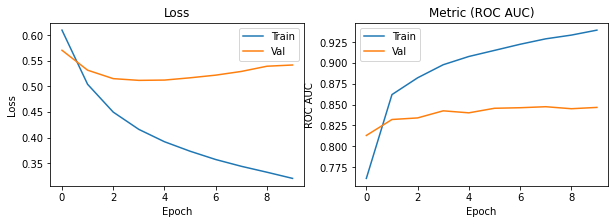

Лучший результат на валидации: 0.8474989911620052


In [ ]:
test_layer_size(500);







Нейронов в скрытом слое: 1000, функция активации: <function relu at 0x7f7baeda3ef0>


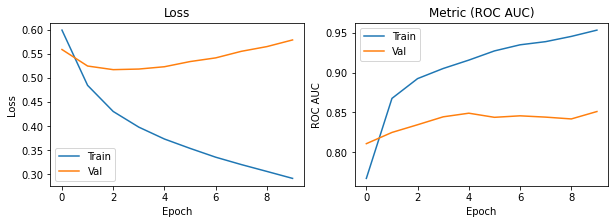

Лучший результат на валидации: 0.8511857042886167


In [ ]:
test_layer_size(1000);

Вывод по подбору размера скрытого слоя:

Результат примерно одинаковый, уже одного нейрона в скрытом слое достаточно, чтобы выйти на уровень обычных линейных алгоритмов. Но больше нейронов, конечно, лучше

На самом деле, результат довольно сильно зависит от случая - для одного нейрона можно получить как 0.81, так и 0.76. В идеале, чтобы исследовать точные границы точности, среднее и дисперсию, нужно провести множество повторяющихся экспериментов для каждого набора параметров. Но для анализа общих закономерностей хватает и таких графиков

Чем больше нейронов, тем быстрее в плане количества эпох обучается модель ("конец" обучения можно выделить как момент, когда лосс на валидации начинается увеличиваться, а точность почти не растет)

Теперь посмотрим на влияние функции активации (в прошлом эксперименте использовалась ReLU):

Нейронов в скрытом слое: 50, функция активации: <function relu at 0x7f7baeda3ef0>


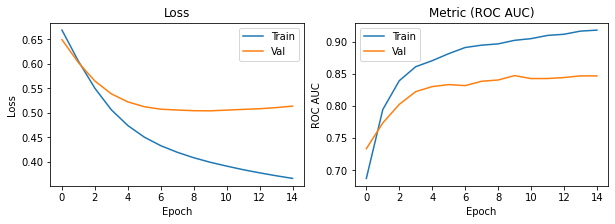

Лучший результат на валидации: 0.8472056649237775


In [ ]:
test_layer_size(50, activation=F.relu, num_epochs=15)

Нейронов в скрытом слое: 50, функция активации: <function elu at 0x7f7baeda6170>


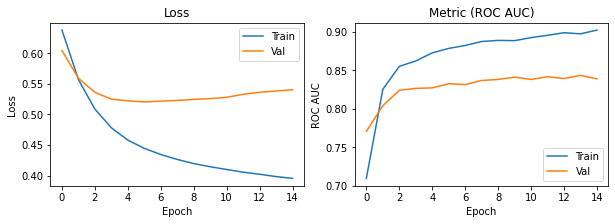

Лучший результат на валидации: 0.8435154970129286


In [ ]:
test_layer_size(50, activation=F.elu, num_epochs=15)

Нейронов в скрытом слое: 50, функция активации: <built-in method sigmoid of type object at 0x7f7ca0ed9e80>


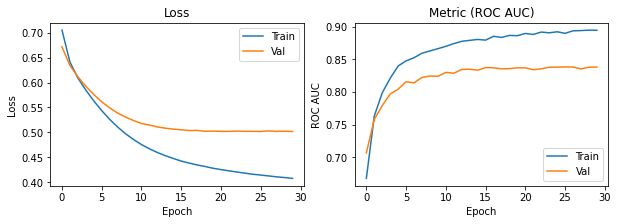

Лучший результат на валидации: 0.8381618053137049


In [ ]:
test_layer_size(50, activation=torch.sigmoid, num_epochs=30)

Нейронов в скрытом слое: 50, функция активации: <function softsign at 0x7f7baeda6680>


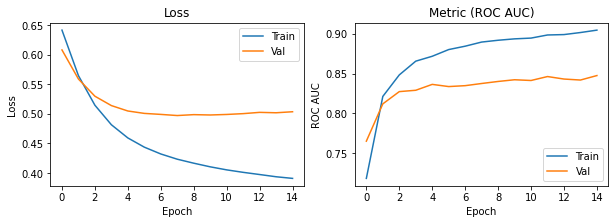

Лучший результат на валидации: 0.8474773039425847


In [ ]:
test_layer_size(50, activation=F.softsign, num_epochs=15)

Нейронов в скрытом слое: 50, функция активации: <built-in method tanh of type object at 0x7f7ca0ed9e80>


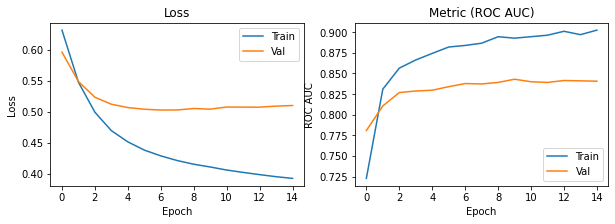

Лучший результат на валидации: 0.8429563445948278


In [ ]:
test_layer_size(50, activation=torch.tanh, num_epochs=15)

Нейронов в скрытом слое: 50, функция активации: <function hardshrink at 0x7f7baeda6560>


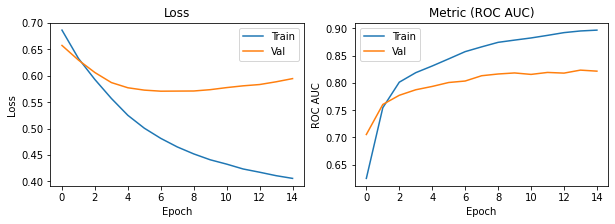

Лучший результат на валидации: 0.8234809065643415


In [ ]:
test_layer_size(50, activation=F.hardshrink, num_epochs=15)

Вывод по подбору функции активации:

Результаты почти одинаковые, кроме Hardshring - с ним результаты хуже. У сигмоиды более плавное обучение, нужно больше эпох

В целом же, разницы в рамках данной задачи и архитектуры нет